# Imports

In [1]:
import os
import cv2
import random
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow import keras

# Instantiate a Pretrained Model

Instantiate a pretrained model to later be used for feature extraction. This notebook uses a [MobileNetV2](https://keras.io/applications/#mobilenetv2) architecture for 96x96 images, with weights pretrained on the ImageNet dataset.

In [2]:
INPUT_WIDTH = 96
INPUT_HEIGHT = 96
pre_trained_model = keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=(INPUT_WIDTH, INPUT_HEIGHT, 3), 
    include_top=False,
    weights='imagenet',
    pooling=None)

last_output = pre_trained_model.output
x = layers.Flatten()(last_output)
pre_trained_model = Model(pre_trained_model.input, x)

pre_trained_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 97, 97, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
______________________________________________________________________________________________

# Load Data

Load data where each category of images is in its own directory.

### Load Data by Category

For each category:
- Create a training batch and validation batch of raw images
- Create a training batch and validating batch of normalized images
- Create labels for training and validation batch

In [3]:
def get_batch(directory, label):
    ims = os.listdir(directory)
    
    train_batch = []
    train_labels = []
    val_batch = []
    val_labels = []

    split_point = round(len(ims) * 0.8)
    split_ims = random.sample(ims, split_point)
    
    for im_name in ims:
        if not (im_name.endswith('.jpg') or im_name.endswith('.jpeg')):
            continue
        im = cv2.imread(directory + im_name)
        im_resize = cv2.cvtColor(cv2.resize(im, dsize=(INPUT_WIDTH, INPUT_HEIGHT), interpolation=cv2.INTER_CUBIC), cv2.COLOR_BGR2RGB)
        
        if im_name in split_ims:
            train_batch.append(im_resize)
            train_labels.append(label)
        else:
            val_batch.append(im_resize)
            val_labels.append(label)
                    
    
    train_batch = np.array(train_batch)
    train_labels = np.array(train_labels)
    val_batch = np.array(val_batch)
    val_labels = np.array(val_labels)

    train_batch_normalized = keras.applications.mobilenet_v2.preprocess_input(train_batch)
    val_batch_normalized = keras.applications.mobilenet_v2.preprocess_input(val_batch)

    return train_batch, val_batch, train_batch_normalized, val_batch_normalized, train_labels, val_labels

### Combine Data

Combine all batches of data from each category together.

In [58]:
sf_dir = 'all_storefronts/'
sf_label = [0, 0, 0, 1]
sf_train_batch, sf_val_batch, sf_train_norm, sf_val_norm, sf_train_labels, sf_val_labels = get_batch(sf_dir, sf_label)

faces_dir = 'all_faces/'
faces_label = [0, 0, 1, 0]
faces_train_batch, faces_val_batch, faces_train_norm, faces_val_norm, faces_train_labels, faces_val_labels = get_batch(faces_dir, faces_label)

ads_dir = 'all_ads/'
ads_label = [0, 1, 0, 0]
ads_train_batch, ads_val_batch, ads_train_norm, ads_val_norm, ads_train_labels, ads_val_labels = get_batch(ads_dir, ads_label)

other_dir = 'all_other/'
other_label = [1, 0, 0, 0]
other_train_batch, other_val_batch, other_train_norm, other_val_norm, other_train_labels, other_val_labels = get_batch(other_dir, other_label)

train_batch = np.concatenate((sf_train_batch, faces_train_batch, ads_train_batch, other_train_batch))
val_batch = np.concatenate((sf_val_batch, faces_val_batch, ads_val_batch, other_val_batch))

train_batch_normalized = np.concatenate((sf_train_norm, faces_train_norm, ads_train_norm, other_train_norm))
val_batch_normalized = np.concatenate((sf_val_norm, faces_val_norm, ads_val_norm, other_val_norm))

train_labels = np.concatenate((sf_train_labels, faces_train_labels, ads_train_labels, other_train_labels))
val_labels = np.concatenate((sf_val_labels, faces_val_labels, ads_val_labels, other_val_labels))

print(train_batch_normalized.shape)
print(val_batch_normalized.shape)

(1360, 96, 96, 3)
(340, 96, 96, 3)


### Feature Extraction with Pretrained Model

Use the pretrained model to extract feature vectors for all normalized images.

In [59]:
train_data = pre_trained_model.predict(train_batch_normalized, verbose=1)
val_data = pre_trained_model.predict(val_batch_normalized, verbose=1)
print(train_data.shape)
print(val_data.shape)

340/340 [==============================] - 2s 5ms/sample
(1360, 11520)
(340, 11520)


# Create a New Classifier

Create a new classifier to classify images into four different classes (storefronts, faces, advertisements, other) based on their extracted feature vectors.

### Model Architecture

Use a softmax activation function for the top layer so that an image cannot be classified into more than one group.

In [151]:
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])

### Training Configuration

Train model with the categorical crossentropy loss function, use the Adam optimizer, and record accuracy during training. Configure checkpoints to save weights of the model during training.

In [152]:
checkpoint_path = "checkpoints/group_images/cp-{epoch:04d}.ckpt"
checkpoint_frequency = 1

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    period=checkpoint_frequency)

# Training

In [153]:
history = model.fit(
    train_data, 
    train_labels,
    batch_size=128,
    epochs=10,
    validation_data=(val_data, val_labels),
    callbacks=[cp_callback],
    verbose=2)

Train on 1360 samples, validate on 340 samples
Epoch 1/10

Epoch 00001: saving model to checkpoints/group_images/cp-0001.ckpt
1360/1360 - 1s - loss: 0.6826 - acc: 0.7787 - val_loss: 0.2501 - val_acc: 0.9206
Epoch 2/10

Epoch 00002: saving model to checkpoints/group_images/cp-0002.ckpt
1360/1360 - 0s - loss: 0.1570 - acc: 0.9463 - val_loss: 0.0941 - val_acc: 0.9794
Epoch 3/10

Epoch 00003: saving model to checkpoints/group_images/cp-0003.ckpt
1360/1360 - 0s - loss: 0.0398 - acc: 0.9853 - val_loss: 0.1009 - val_acc: 0.9824
Epoch 4/10

Epoch 00004: saving model to checkpoints/group_images/cp-0004.ckpt
1360/1360 - 0s - loss: 0.0136 - acc: 0.9971 - val_loss: 0.1115 - val_acc: 0.9735
Epoch 5/10

Epoch 00005: saving model to checkpoints/group_images/cp-0005.ckpt
1360/1360 - 0s - loss: 0.0136 - acc: 0.9949 - val_loss: 0.1352 - val_acc: 0.9765
Epoch 6/10

Epoch 00006: saving model to checkpoints/group_images/cp-0006.ckpt
1360/1360 - 0s - loss: 0.0054 - acc: 0.9978 - val_loss: 0.1246 - val_acc: 

# Plot Metrics

Plot the training/validation loss and accuracy collected during training.

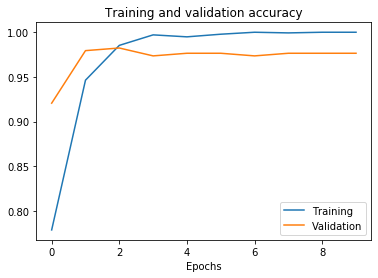

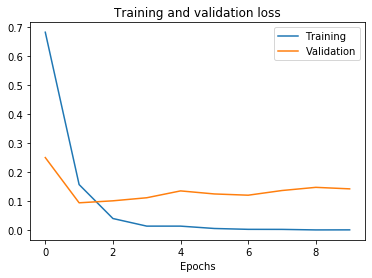

In [154]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of loss results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

%matplotlib inline

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label='Training')
plt.plot(epochs, val_acc, label='Validation')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label='Training')
plt.plot(epochs, val_loss, label='Validation')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.legend()

# Load Checkpoint

Select a checkpoint from training to use to classify images.

In [155]:
load_checkpoint = 'checkpoints/group_images/cp-0003.ckpt'
model.load_weights(load_checkpoint)

# View Predictions

Show test images along with the model's prediction compared to the expected value.

### Get Predictions

In [156]:
predictions = model.predict(val_data)

### View Random Sample of Predictions

View 20 random predictions from the trained model. Images are labeled with the model's prediction, its actual label, and the models confidence of its prediction.

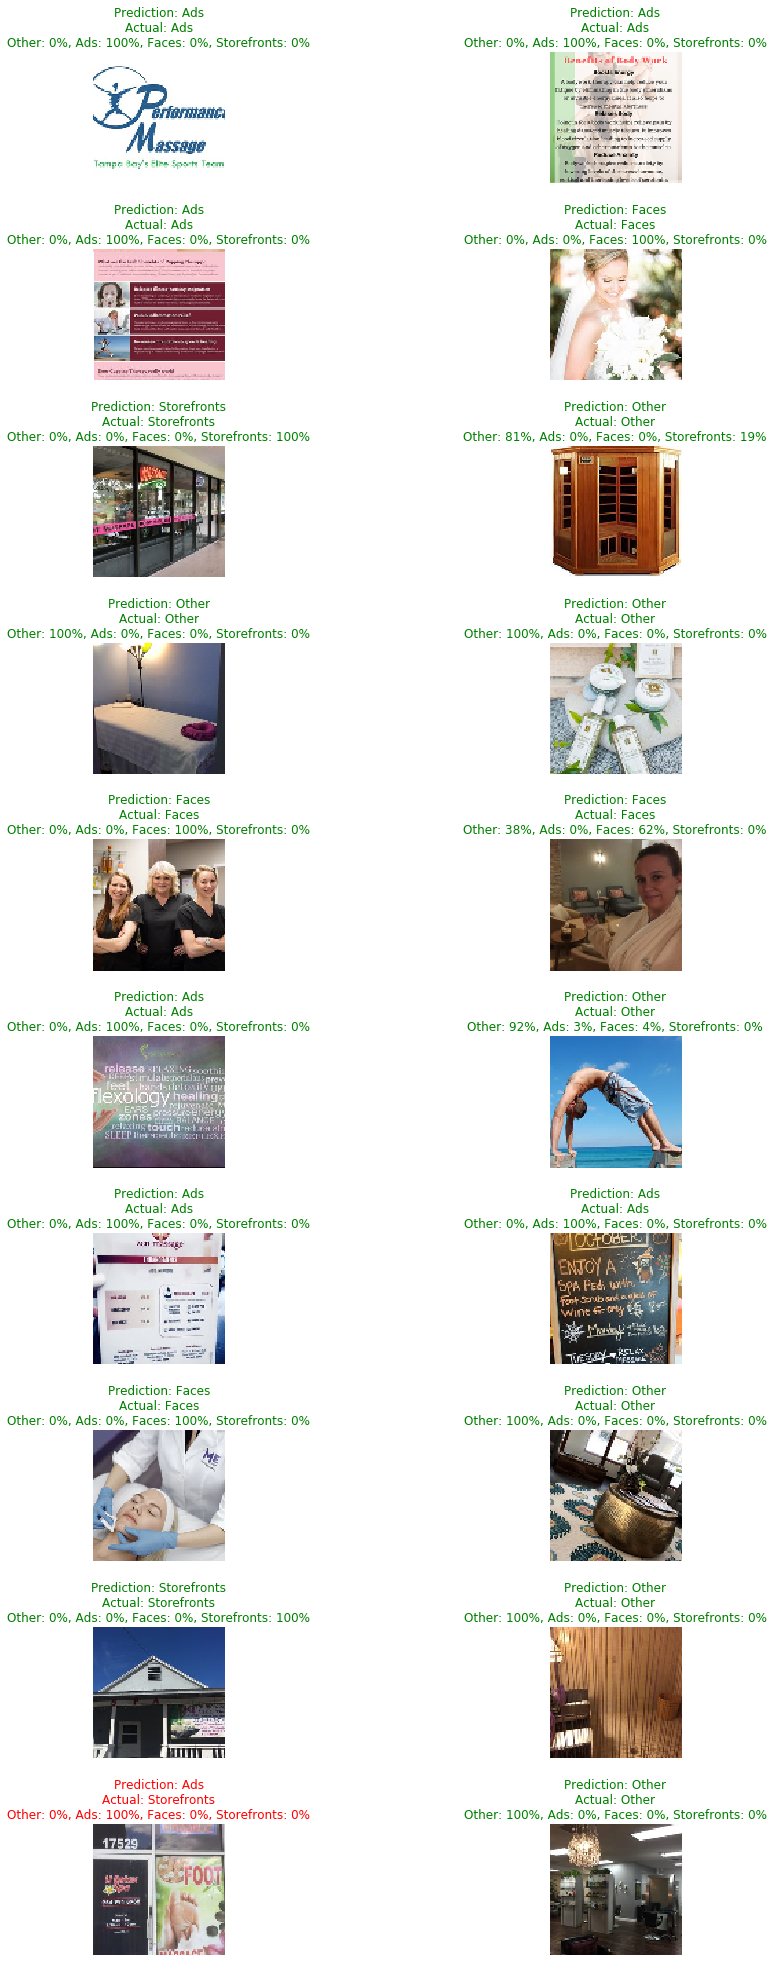

In [157]:
title_labels = ['Other', 'Ads', 'Faces', 'Storefronts']

sample = random.sample(range(len(predictions)), 20)

plt.figure(figsize=(15, 35))
plt.subplots_adjust(hspace=0.5)
n = 0
for i in sample:
    prediction = np.argmax(predictions[i])
    actual = np.argmax(val_labels[i])
    plt.subplot(10,2,n+1)
    n += 1
    plt.imshow(val_batch[i])
    confidence = '\nOther: ' + str(int(round(predictions[i][0] * 100))) + \
                 '%, Ads: ' + str(int(round(predictions[i][1] * 100))) + \
                 '%, Faces: ' + str(int(round(predictions[i][2] * 100))) + \
                 '%, Storefronts: ' + str(int(round(predictions[i][3] * 100))) + '%'
    title = 'Prediction: ' + title_labels[prediction] + '\nActual: ' + title_labels[actual] + confidence
    title_obj = plt.title(title)
    if prediction == actual:
        plt.setp(title_obj, color='g')
    else:
        plt.setp(title_obj, color='r')
    plt.axis('off')

### View Incorrect Predictions

View only the incorrect predictions of the trained model.

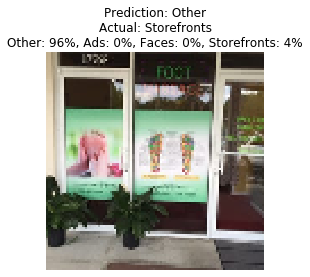

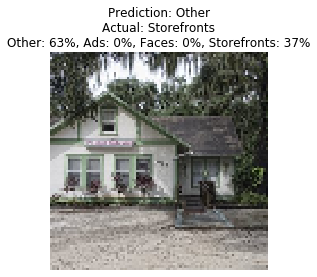

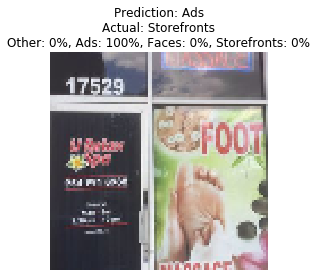

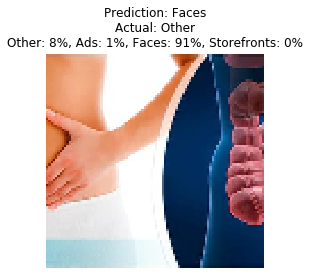

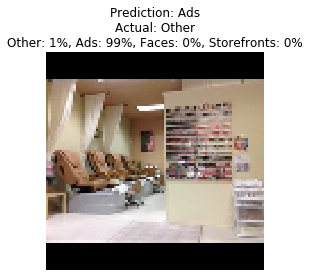

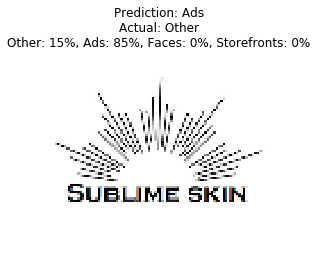

In [158]:
title_labels = ['Other', 'Ads', 'Faces', 'Storefronts']

for i in range(len(predictions)):
    prediction = np.argmax(predictions[i])
    actual = np.argmax(val_labels[i])
    if prediction != actual:
        plt.figure()
        plt.imshow(val_batch[i])
        confidence = '\nOther: ' + str(int(round(predictions[i][0] * 100))) + \
                     '%, Ads: ' + str(int(round(predictions[i][1] * 100))) + \
                     '%, Faces: ' + str(int(round(predictions[i][2] * 100))) + \
                     '%, Storefronts: ' + str(int(round(predictions[i][3] * 100))) + '%'
        title = 'Prediction: ' + title_labels[prediction] + '\nActual: ' + title_labels[actual] + confidence
        plt.title(title)
        plt.axis('off')

# Save Model

In [159]:
model.save('group_images_96.h5')